# Transient Fickian Diffusion with Reaction
`OpenPNM` supports adding reaction terms to both steady state and transient simulations. `OpenPNM` already includes many different source term models that can be added to simulate a reaction. In this example, we show how to add a `powerlaw` source term model to a transient fickian diffusion simulation.

Start by importing openpnm

In [1]:
import openpnm as op
import matplotlib.pyplot as plt
import numpy as np
ws = op.Workspace()
proj = ws.new_project()
np.random.seed(10)

# Define network, geometry, and phase objects

In [2]:
net = op.network.Cubic(shape=[25, 25, 1], spacing=1e-4)
geo = op.geometry.StickAndBall(network=net, pores=net.Ps, throats=net.Ts)
phase = op.phases.Water(network=net)

You can adjust the diffusion coefficient by calling the `pore.diffusivity` dictionary key on the phase object and then setting it's value.

In [3]:
phase['pore.diffusivity'] = 2e-09

# Define physics object 
Here, we will use `Standard` physics which already includes many standard models. You could also use `Generic` physics and add neccessary models like `throat.diffusive_conductance` after using `phys.add_model()` method.

In [4]:
phys = op.physics.Standard(network=net, phase=phase, geometry=geo)

# Add reaction model 
Add reaction model to physics object. For this example we use the `powerlaw` reaction model which is of the form:

\begin{equation*}
\ A_1X^{A_2}
\end{equation*}

In [5]:
phase['pore.concentration'] = 0
phys['pore.rxnA'] = -1e-10
phys['pore.rxnb'] = 1
phys.add_model(propname='pore.reaction', model=op.models.physics.generic_source_term.power_law,
               A1='pore.rxnA', A2='pore.rxnb', X='pore.concentration')

# Define transient fickian diffusion object 

In [6]:
tfd = op.algorithms.TransientFickianDiffusion(network=net, phase=phase)

# Setup the transient algorithm settings
To do this you can call the `tfd.setup()` method and use it to set settings such as transient solver scheme, final time, time step, tolerance, etc. The `cranknicolson` scheme used here is the most accurate but slowest. Other time schemes are `implicit` which is faster but less accurate and `steady` which gives the steady state solution. 

In [7]:
tfd.setup(t_scheme='cranknicolson', t_final=1000, t_output=100, t_step=1, t_tolerance=1e-12)

# Set value boundary conditions
In this example we set the concentraton of the `front` pores to 1 and the concentration of the `back` pores to 0.

In [8]:
tfd.set_value_BC(pores=net.pores('front'), values=1)
tfd.set_value_BC(pores=net.pores('back'), values=0)

# Set initial condition
This command sets all pores to 0 (or whatever value you set) to start the simulation.

In [9]:
tfd.set_IC(values=0)

# Set source term
In this example, we apply the source term to pores 212 and 412. 

In [10]:
tfd.set_source(propname='pore.reaction', pores=[212, 412])

# Run the simulation

In [11]:
tfd.run()

# Visualize results
Ater simulation runs we can visualize results using a colour plot from `matplotlib.pyplot`. Here we visualize the results at the final time `t_final` by using the `pore.concentration` key on the algorithm object.

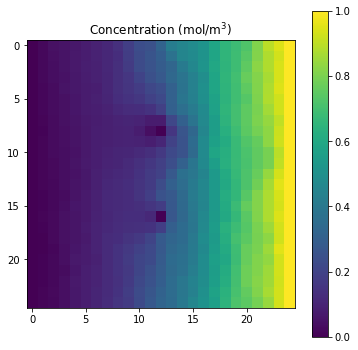

In [12]:
c = tfd['pore.concentration'].reshape((net._shape))
fig, ax = plt.subplots(figsize=(6, 6))
plt.imshow(c[:,:,0])
plt.title('Concentration (mol/m$^3$)')
plt.colorbar();

If we print the `TransientFickianDiffusion` object we can see a list of the object's properties. Notice how the concentration is recorded here for each output concentration, `t_output`.

In [13]:
print(tfd)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
openpnm.algorithms.TransientFickianDiffusion : alg_01
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
#     Properties                                    Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
1     pore.bc_rate                                      0 / 625  
2     pore.bc_value                                    50 / 625  
3     pore.concentration                              625 / 625  
4     pore.concentration@0                            625 / 625  
5     pore.concentration@100                          625 / 625  
6     pore.concentration@1000                         625 / 625  
7     pore.concentration@200                          625 / 625  
8     pore.concentration@300                          625 / 625  
9     pore.concentration@400                          625 / 625  
10    pore.concentration@500                      

We can visualize intermediate concentration profiles using a colour plot but use `pore.concentration@100` (or similar) as the dictionary key on the algorithm object.

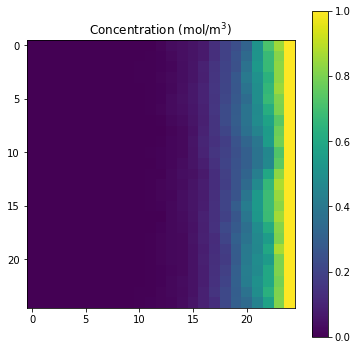

In [14]:
c = tfd['pore.concentration@100'].reshape((net._shape))
fig, ax = plt.subplots(figsize=(6, 6))
plt.imshow(c[:,:,0])
plt.title('Concentration (mol/m$^3$)')
plt.colorbar();